# Huckleberry Labs Interview

Prompt:

```
1. Read the data

2. Prepare the data for modeling the value in the column named "real_or_fake?" (1 for real and 0 for fake)

3. Model the prediction of the column named "real_or_fake?"

4. Show how you have developed the method of scoring the models

5. The modeling with the best metric is far less important than the methodology used to perform steps 2-4
```

In [1]:
import string
import contractions
from spellchecker import SpellChecker
from wordcloud import STOPWORDS
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn import svm
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

import gensim
from gsdmm import MovieGroupProcess

pd.options.mode.chained_assignment = None 
sns.set_context("notebook")
np.random.seed(42)

nlp = spacy.load("en_core_web_lg")

## Load the data


In [2]:
df = pd.read_csv('presentation_data.csv')

In [3]:
df

,index_val,type_val,place,short_text,real_or_fake
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@ Aria Ahrary @ TheTawniest The out of contr...,1
7610,10871,NaN,NaN,M1 . 94 [ 01 : 04 UTC ] ? 5km S of Volcano H...,1
7611,10872,NaN,NaN,Police investigating after an e - bike collide...,1


<AxesSubplot:xlabel='real_or_fake', ylabel='count'>

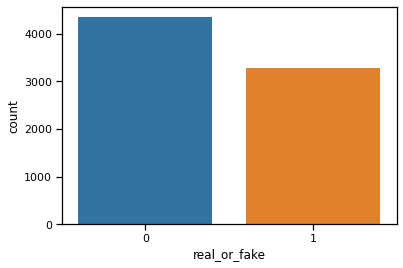

In [4]:
sns.countplot(x = 'real_or_fake', data=df) # not bad

### Impressions
- This text data seems to be Twitter data, which means that `place` will not be useful because this field is generated by the user and doesn't necessarily contain a real place
- Let's see if `type_val` contains any useful information

In [5]:
df['type_val'].unique()[0:50]

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide'], dtype=object)

In [6]:
real_type_val = df.query("real_or_fake == 1")['type_val'].value_counts().reset_index().iloc[0:20]
fake_type_val = df.query("real_or_fake == 0")['type_val'].value_counts().reset_index().iloc[0:20]

<AxesSubplot:xlabel='type_val', ylabel='index'>

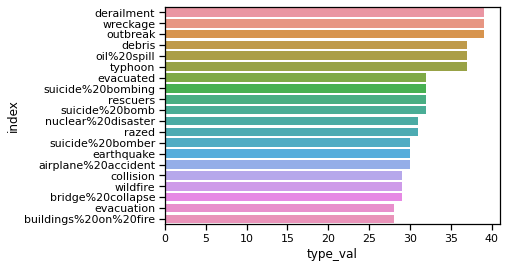

In [7]:
sns.barplot(y = 'index', x = 'type_val', data = real_type_val)

<AxesSubplot:xlabel='type_val', ylabel='index'>

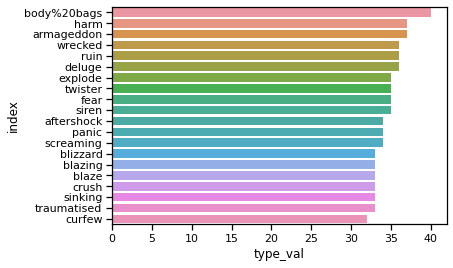

In [8]:
sns.barplot(y = 'index', x = 'type_val', data = fake_type_val)

- `type_val` may contain useful information since there is good separation between real and fake but it requires heavy cleaning
- for the model to be properly robust, especially for new data, we should use topic modeling strategies to create our own `type_val`
- Use raw text data for topic modeling

## Pre-processing of Raw Text Data

In [9]:
len(df['index_val'].unique()) == len(df['index_val']) # check for duplicate indexes

True

In [10]:
# check for duplicates in `short_text`

df[df.duplicated(subset=['short_text'])]

# 632 duplicates is a lot. Let's check if the duplicates were consistently classified as real or fake 

,index_val,type_val,place,short_text,real_or_fake
48,68,ablaze,Live On Webcam,Check these out : # nsfw,0
106,156,aftershock,US,320 [ IR ] ICEMOON [ AFTERSHOCK ] | | ...,0
114,164,aftershock,Switzerland,320 [ IR ] ICEMOON [ AFTERSHOCK ] | | ...,0
115,165,aftershock,US,320 [ IR ] ICEMOON [ AFTERSHOCK ] | | ...,0
116,168,aftershock,NaN,320 [ IR ] ICEMOON [ AFTERSHOCK ] | | ...,0
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@ Aria Ahrary @ TheTawniest The out of contr...,1
7610,10871,NaN,NaN,M1 . 94 [ 01 : 04 UTC ] ? 5km S of Volcano H...,1
7611,10872,NaN,NaN,Police investigating after an e - bike collide...,1


In [11]:
dupes_mean = df.groupby('short_text').mean()
dupes_mean

# if the mean is not 0 or 1, then that means that `real_or_fake` was inconsistent between duplicates
# let's drop the inconsistencies for now. 
# but in reality we would be double checking 1) why duplicates occurred (scraping or API issue?) and 2) why were they categorized differently?

,index_val,real_or_fake
short_text,,
\nANOTHER DISASTER WAITING TO HAPPEN AND YOUR ALLOWING IT ?,7255.0,1.0
\nCROYDON RIOTS - The Next Day : Burning Buildings in High Street & crowds at Reeves Corner\nCroydonization\nAugust 2011,1770.0,1.0
\nSON OF SAVIOR LAVA VIDEO,6724.0,0.0
\nSeems they declared war against government .,6455.0,1.0
# ArtisteOfTheWeekFact say # Conversations by # coast2coastdjs agree @ Crystal_Blaz ' s # Jiwonle is a # HipHop # ClubBanger,978.0,0.0
...,...,...
you wrecked my whole world,10811.0,0.0
~ More wicked weather rolls through Calgary and surrounding areas,5847.0,1.0
~Still echoes of their screams~,8560.0,0.0


In [12]:
dupes_mean.query("real_or_fake != 1 & real_or_fake != 0")

,index_val,real_or_fake
short_text,,
Cindy Noonan @ Cindy Noonan - Heartbreak in # Baltimore # Rioting # YAHIstorical # Underground Railraod,8271.000000,0.500000
# 360WiseNews : China ' s Stock Market Crash : Are There Gems In The Rubble ?,8322.500000,0.500000
# Allah describes piling up # wealth thinking it would last # forever as the description of the people of # Hellfire in Surah Humaza . # Reflect,6107.333333,0.333333
# food scare # offers to go # Nestle India slips into loss after # Magginoodle # ban unsafe and hazardous for # human consumption,6016.666667,0.666667
# hot C - 130 specially modified to land in a stadium and rescue hostages in Iran in 1980 # prebreak # best,6356.875000,0.875000
...,...,...
World Annihilation vs Self Transformation Aliens Attack to Exterminate Humans,371.500000,0.500000
World War II book LIGHTNING JOE An Autobiography by General J . Lawton Collins,6781.500000,0.500000
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1855.000000,0.500000


In [13]:
remove_text = dupes_mean.query("real_or_fake != 1 & real_or_fake != 0").reset_index()['short_text'].to_list()

In [14]:
len(remove_text)

66

In [15]:
df.query('short_text not in @remove_text', inplace=True)
df

# Shouldn't necessarily remove duplicates because retweets contain information too

,index_val,type_val,place,short_text,real_or_fake
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@ Aria Ahrary @ TheTawniest The out of contr...,1
7610,10871,NaN,NaN,M1 . 94 [ 01 : 04 UTC ] ? 5km S of Volcano H...,1
7611,10872,NaN,NaN,Police investigating after an e - bike collide...,1


In [16]:
# we need to be able to grab contractions and expand them
# the raw data has a space to separate the word "can ' t" -> "can't"

df['short_text'] = df['short_text'].str.replace(" ' ", "'") # make the contractions again
df['short_text'] = df['short_text'].apply(lambda x: contractions.fix(x)) # expand contractions

In [17]:
# now we removed input with inconsistent real_or_fake
# lets keep cleaning

df['clean_text'] = df['short_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['clean_text'] = df['clean_text'].str.replace('[^a-zA-Z]', ' ', regex=True) # remove numbers, keep only letters
df['clean_text'] = df['clean_text'].str.replace('\s+', ' ', regex=True) # remove multiple spaces

In [18]:
df['lower_clean_text'] = df['clean_text'].str.lower()
df['spell_checked_text'] = df['lower_clean_text'] 

In [19]:
spell = SpellChecker()

df['spell_checked_text'] = df['spell_checked_text'].apply(lambda x: spell.correction(x))

# slow 😴

In [20]:
# let's remove some stopwards

df['super_clean_text'] = df['spell_checked_text'].apply(lambda x: [item for item in x.split(' ') if item not in STOPWORDS])
df['super_clean_text'] = df['super_clean_text'].apply(lambda strings: [x for x in strings if x]) # remove empty strings


In [21]:
df['temp_docs'] = df['super_clean_text'].str.join(' ').apply(lambda x: nlp(x))
df['lemmatized_text'] = df['temp_docs'].apply(lambda x: " ".join([token.lemma_ for token in x]))

In [22]:
df['lemmatized_text'] = df['lemmatized_text'].str.replace('\s+', ' ', regex=True) # remove multiple spaces

## N-Gram Generation

In [23]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

real_unigrams = defaultdict(int)
fake_unigrams = defaultdict(int)

real_bigrams = defaultdict(int)
fake_bigrams = defaultdict(int)

real_trigrams = defaultdict(int)
fake_trigrams = defaultdict(int)

for text in df.query("real_or_fake == 1")['spell_checked_text']:
    for word in generate_ngrams(text, n_gram=1):
        real_unigrams[word] += 1
    for word in generate_ngrams(text, n_gram=2):
        real_bigrams[word] += 1
    for word in generate_ngrams(text, n_gram=3):
        real_trigrams[word] += 1
        
for text in df.query("real_or_fake == 0")['spell_checked_text']:
    for word in generate_ngrams(text, n_gram=1):
        fake_unigrams[word] += 1
    for word in generate_ngrams(text, n_gram=2):
        fake_bigrams[word] += 1
    for word in generate_ngrams(text, n_gram=3):
        fake_trigrams[word] += 1

def create_df_from_sorted_dct(dct): 
    df = pd.DataFrame(sorted(dct.items(), key=lambda x: x[1])[::-1])
    df.columns = ['ngram', 'frequency']
    df = df.iloc[:20] # just take the top 20 words
    return df

In [24]:
df_real_uni = create_df_from_sorted_dct(real_unigrams)
df_fake_uni = create_df_from_sorted_dct(fake_unigrams)

df_real_bi = create_df_from_sorted_dct(real_bigrams)
df_fake_bi = create_df_from_sorted_dct(fake_bigrams)

df_real_tri = create_df_from_sorted_dct(real_trigrams)
df_fake_tri = create_df_from_sorted_dct(fake_trigrams)

<AxesSubplot:xlabel='frequency', ylabel='ngram'>

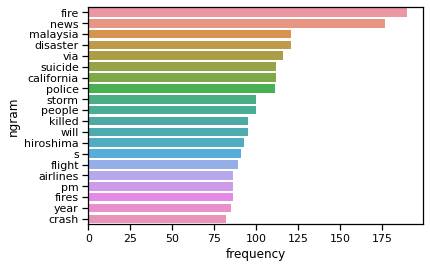

In [25]:
# Real Unigram
sns.barplot(y = 'ngram', x = 'frequency', data = df_real_uni)

<AxesSubplot:xlabel='frequency', ylabel='ngram'>

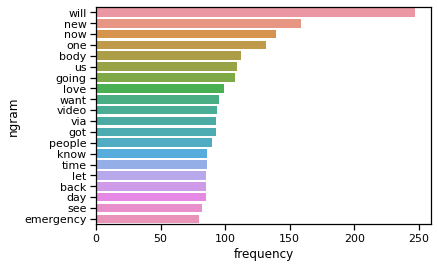

In [26]:
# Fake Unigram
sns.barplot(y = 'ngram', x = 'frequency', data = df_fake_uni)

<AxesSubplot:xlabel='frequency', ylabel='ngram'>

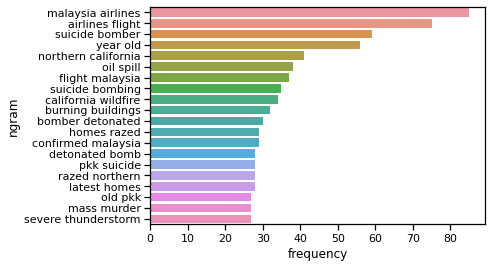

In [27]:
# Real Bigram
sns.barplot(y = 'ngram', x = 'frequency', data = df_real_bi)

<AxesSubplot:xlabel='frequency', ylabel='ngram'>

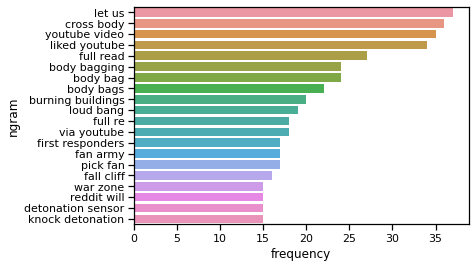

In [28]:
# Fake Bigram
sns.barplot(y = 'ngram', x = 'frequency', data = df_fake_bi)

<AxesSubplot:xlabel='frequency', ylabel='ngram'>

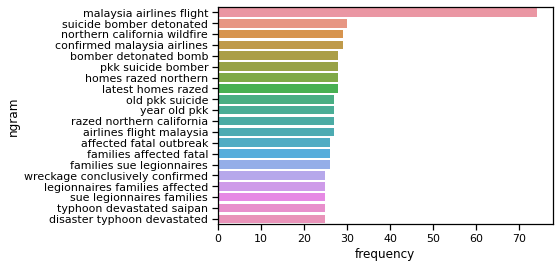

In [29]:
# Real Trigram
sns.barplot(y = 'ngram', x = 'frequency', data = df_real_tri)

<AxesSubplot:xlabel='frequency', ylabel='ngram'>

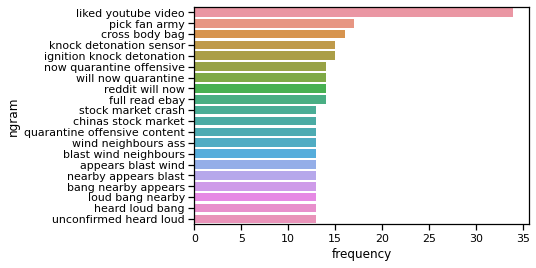

In [30]:
# Fake Trigram
sns.barplot(y = 'ngram', x = 'frequency', data = df_fake_tri)

## Individual Topic Modeling from using GSDMM
-  Gibbs sampling algorithm for a Dirichlet Mixture Model is more appropriate for short text and matches our assumption that there should only be one topic per row
- https://github.com/rwalk/gsdmm

In [31]:
# input needs to be a list of lists of string
lst_strings = df['lemmatized_text'].apply(lambda x: x.split(' '))
gsdmm_docs = [list(filter(None, lst)) for lst in lst_strings] # remove blank strings
gsdmm_docs = [x for x in gsdmm_docs if len(x) > 2]

# create dictionary of all words in all documents
gsdmm_dct = gensim.corpora.Dictionary(gsdmm_docs)

# filter extreme cases out of dictionary
gsdmm_dct.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# create variable containing length of dictionary/vocab
vocab_length = len(gsdmm_dct)

# create bag of words dictionary
bow_corpus = [gsdmm_dct.doc2bow(doc) for doc in gsdmm_docs]

# initialize GSDMM
# arbitrary hyperparameters here, assume 15 clusters
gsdmm = MovieGroupProcess(K=15, alpha=0.5, beta=0.1, n_iters=15)
# Alpha controls the probability that a student will join a table that is currently empty
# beta: Beta controls the student's affinity for other students with similar interests. Low means higher affinity and less on popularity

# fit GSDMM model
gsdmm_out = gsdmm.fit(gsdmm_docs, vocab_length)

In stage 0: transferred 5859 clusters with 15 clusters populated
In stage 1: transferred 2961 clusters with 15 clusters populated
In stage 2: transferred 2132 clusters with 15 clusters populated
In stage 3: transferred 1742 clusters with 15 clusters populated
In stage 4: transferred 1626 clusters with 15 clusters populated
In stage 5: transferred 1508 clusters with 15 clusters populated
In stage 6: transferred 1418 clusters with 15 clusters populated
In stage 7: transferred 1341 clusters with 15 clusters populated
In stage 8: transferred 1296 clusters with 15 clusters populated
In stage 9: transferred 1242 clusters with 15 clusters populated
In stage 10: transferred 1192 clusters with 15 clusters populated
In stage 11: transferred 1190 clusters with 15 clusters populated
In stage 12: transferred 1197 clusters with 15 clusters populated
In stage 13: transferred 1211 clusters with 15 clusters populated
In stage 14: transferred 1171 clusters with 15 clusters populated


In [32]:
# print number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topic
top_words(gsdmm.cluster_word_distribution, top_index, 20)

Number of documents per topic : [ 389  405  453  470  508  352  658  543  389  399  374 1142  313  411
  372]
Most important clusters (by number of docs inside): [11  6  7  4  3  2 13  1  9  8  0 10 14  5 12]

Cluster 11 : [('go', 112), ('will', 83), ('want', 72), ('make', 69), ('see', 63), ('people', 61), ('now', 60), ('time', 60), ('get', 60), ('good', 56), ('scream', 54), ('think', 54), ('let', 49), ('know', 49), ('love', 47), ('panic', 46), ('one', 45), ('come', 41), ('we', 40), ('blow', 39)]

Cluster 6 : [('go', 64), ('one', 40), ('will', 37), ('school', 34), ('mudslide', 34), ('look', 32), ('say', 31), ('know', 30), ('year', 30), ('s', 29), ('crash', 28), ('drown', 28), ('survive', 27), ('failure', 26), ('cake', 24), ('back', 23), ('next', 23), ('get', 23), ('structural', 23), ('fire', 22)]

Cluster 7 : [('body', 78), ('bag', 67), ('burn', 53), ('building', 39), ('new', 30), ('will', 30), ('fall', 30), ('cliff', 29), ('cross', 24), ('go', 23), ('meek', 21), ('shoulder', 20), ('ge

In [33]:
# finally, lets get the cluster information for each text
df['cluster'] = df['lemmatized_text'].str.split(' ').apply(lambda x: gsdmm.choose_best_label(x)[0])

<AxesSubplot:xlabel='cluster', ylabel='count'>

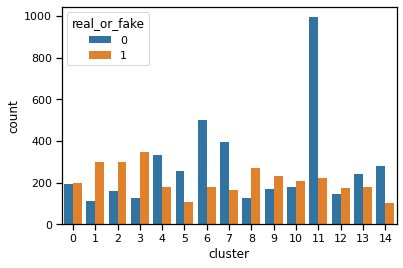

In [34]:
sns.countplot(x = 'cluster', hue='real_or_fake', data=df)
# some clusters perform better than others. clustering needs some optimization

### Cluster 11 information:

```
Cluster 11 : [('go', 112), ('will', 83), ('want', 72), ('make', 69), ('see', 63), ('people', 61), ('now', 60), ('time', 60), ('get', 60), ('good', 56), ('scream', 54), ('think', 54), ('let', 49), ('know', 49), ('love', 47), ('panic', 46), ('one', 45), ('come', 41), ('we', 40), ('blow', 39)]
```

- No event specific words, so it makes sense that it has a high number of 0 for `real_or_fake`

### Cluster 1, 2, and 3 information:

- In contrast, let's check Clusters 1, 2, and 3, which have a relatively low number of "fake":

```
Cluster 1 : [('suicide', 81), ('hiroshima', 79), ('kill', 68), ('bomb', 62), ('bombing', 61), ('atomic', 50), ('year', 46), ('japan', 39), ('saudi', 39), ('mosque', 35), ('attack', 34), ('anniversary', 34), ('nuclear', 32), ('bomber', 32), ('war', 31), ('still', 26), ('one', 23), ('weapon', 23), ('police', 22), ('today', 22)]

Cluster 2 : [('storm', 61), ('weather', 60), ('thunderstorm', 51), ('pm', 49), ('severe', 41), ('rain', 38), ('issue', 33), ('come', 31), ('hail', 31), ('fire', 30), ('calgary', 30), ('wind', 30), ('city', 28), ('warning', 26), ('derail', 25), ('august', 25), ('flood', 23), ('will', 22), ('train', 22), ('warn', 21)]

Cluster 3 : [('fire', 194), ('building', 51), ('collapse', 42), ('forest', 41), ('california', 35), ('sinkhole', 34), ('burn', 33), ('evacuation', 29), ('home', 27), ('service', 27), ('bridge', 26), ('truck', 25), ('wild', 25), ('wildfire', 25), ('news', 24), ('two', 24), ('evacuate', 23), ('emergency', 19), ('order', 19), ('will', 18)]
```

We can see that it makes sense for these clusters have good separation between real and fake. These clusters could use some optimization, however.

Now that we created our clusters, we can move on to vectorizing the lemmatized text


## Create TF-IDF Vector Feature
- vectorize text data into numerical format
- **Term frequency - inverse document frequency**: quantify the importance of string representations in the context of the whole dataset
- Proportionally accounts for the number of occurrences of a string in a Tweet, the number of Tweets containing that string, and the total number of Tweets


In [35]:
vocab = set()
for s in df['temp_docs']:
    vocab.update(set(s))

In [36]:
vectors = []
for token in list(vocab):
    vectors.append(token.vector)

In [37]:
vect = TfidfVectorizer()
tfidf_matrix = vect.fit_transform(df['lemmatized_text'])
results_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names_out())
results_df

# wow, we really need to clean this dataset up better at future passes

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aaceorg,aal,aan,aannnnd,aar,...,zoom,zotar,zouma,zourryart,zrnf,zss,zumiez,zurich,zxathetis,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
cluster_array = pd.get_dummies(data = df['cluster'], columns=['cluster']) # dummy variables for clusters

In [39]:
X_cluster = cluster_array.to_numpy()

In [40]:
X_tfidf = tfidf_matrix.toarray()

In [41]:
X = np.concatenate((X_cluster, X_tfidf), axis=1) # concatenate arrays into 1 array

In [42]:
y = df['real_or_fake']
# 80/20/split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['cluster'], shuffle=True)

In [43]:
# Initialize SVM classifier
svm_clf = svm.SVC(kernel='linear')
svm_clf = svm_clf.fit(X_train, y_train)

In [44]:
svm_y_pred = svm_clf.predict(X_test)

## Plot Confusion Matrix

/Users/johntan/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


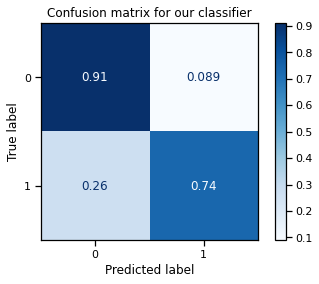

In [45]:
matrix = plot_confusion_matrix(svm_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

## Model Scoring

In [46]:
def metrics_fx(y_true, y_pred):
    
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    
    return pd.DataFrame([accuracy, precision, recall, auc, f1], index = ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1'])

In [47]:
results_metrics = metrics_fx(y_test, svm_y_pred)
results_metrics

,0
Accuracy,0.836831
Precision,0.858473
Recall,0.736422
AUC,0.823558
F1,0.792777


## Cross-Validation


In [48]:
# Don't run, WILL CRASH

# cv = RepeatedKFold(n_splits=10, n_repeats=3)
# scores = cross_val_score(svm_clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# Comparison to HuggingFace's ![AutoNLP](https://huggingface.co/autonlp)

Input: `short_text` and `real_or_fake`

In [49]:
results_metrics.columns = ['Mine']
results_metrics['HuggingFace'] = [0.8589238845144357, 0.8754266211604096, 0.783206106870229, 0.8951976036332013, 0.8267526188557615]

In [50]:
results_metrics.round(3)
# So close!

,Mine,HuggingFace
Accuracy,0.837,0.859
Precision,0.858,0.875
Recall,0.736,0.783
AUC,0.824,0.895
F1,0.793,0.827


# Conclusions

- Data needs to be cleaned more. Slang strings and informal writing (i.e. “aaaaaaannnnnndddd,” “loooooooooool”) need to be accounted for
- Clustering via GSDMM hyperparameters could be optimized better
- Better vectorization strategy than TF-IDF
- External validation - connect with Twitter API and see how well new Tweets can detect events
- If possible, train the model on only verified Twitter accounts to reduce noise and increase possibility of “real”
